In [1]:
import pandas as pd  
import numpy as np

#==== Data visualization =====
import matplotlib.pyplot as plt 
import seaborn as sns

#==== Regular expressions and string processing ====
import re
import string

#==== Model persistence ====
import pickle

#==== Suppress warnings for cleaner output ====
import warnings
warnings.filterwarnings('ignore')

# ==== NLP Libraries ====
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

# ==== Machine Learning Libraries ====
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Download essential NLTK resources (run once, comment out after first run)
nltk.download('punkt')       # sentence + word tokenizer models
nltk.download('punkt_tab')   # new in NLTK 3.9+, needed for word_tokenize
nltk.download('stopwords')   # for stopword removal
nltk.download('wordnet')  

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\faisa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\faisa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\faisa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\faisa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
movie_df = pd.read_csv('IMDB Dataset.csv')

In [4]:
movie_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
print("Dataset shape:", movie_df.shape)

Dataset shape: (50000, 2)


In [6]:
print("\nMissing values in movie_review data:")
print(movie_df.isnull().sum())


Missing values in movie_review data:
review       0
sentiment    0
dtype: int64


In [7]:
movie_df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

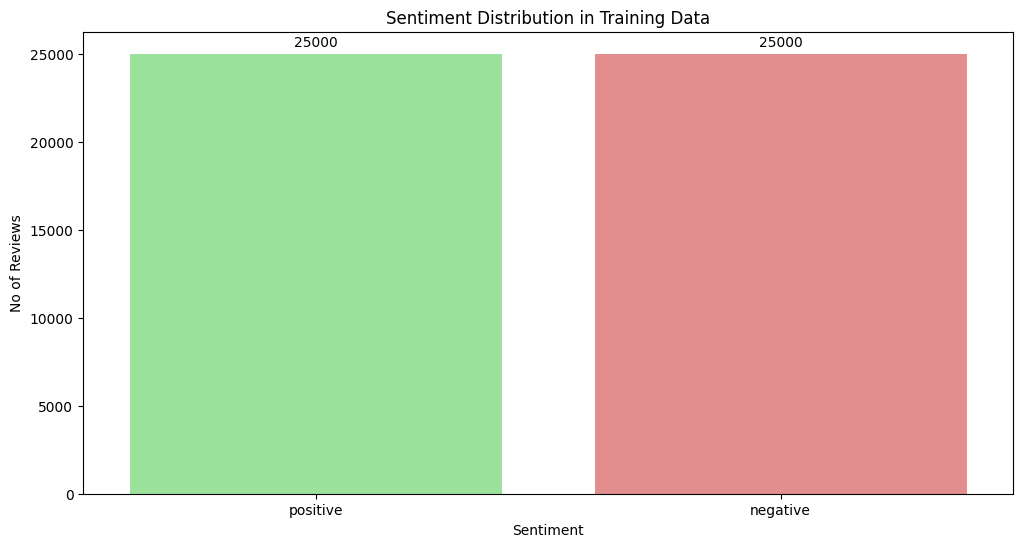

In [8]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    x='sentiment',
    data=movie_df,
    palette={'negative': 'lightcoral', 'positive': 'lightgreen'}
)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.title('Sentiment Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('No of Reviews')
plt.show()

In [9]:
# Convert 'text' to string to avoid errors with NaN (float) values
movie_df['review'] = movie_df['review'].astype(str)

In [10]:
# Explore text length distribution
movie_df['review_length'] = movie_df['review'].apply(len)

In [11]:
movie_df.head()

,review,sentiment,review_length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


<h3><em>Text preprocessing</em></h3>

In [12]:
# Preload resources (faster than calling inside function)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [13]:
def preprocess_text(text):
    if not isinstance(text, str):
        return []

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    text = text.lower()  # lowercase
    text = re.sub(r'\d+', '', text)  # remove numbers

    # Tokenize using NLTK
    tokens = word_tokenize(text)

    # Keep only alphabetic tokens and remove stopwords
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

In [14]:
story = movie_df['review'].apply(preprocess_text).tolist()

In [15]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    sentences=story,
    vector_size=100,
    window=5,
    min_count=5,
    sg=1,
    workers=8,
    hs=0, 
    negative=5
)

In [16]:
w2v_model.build_vocab(story)
w2v_model.train(story, total_examples = w2v_model.corpus_count, epochs=5)

(26700944, 28627965)

In [17]:
# Extract vocabulary set in main process
vocab_set = set(w2v_model.wv.index_to_key)

def tokenize_review_safe(review, vocab):
    if not isinstance(review, str):
        return []
    return [w for w in review.split() if w in vocab]


import swifter

movie_df['tokens'] = movie_df['review'].swifter.apply(lambda x: tokenize_review_safe(x, vocab_set))

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

In [18]:
# # Document vector function
# def document_vector_fast(tokens):
#     if len(tokens) == 0:
#         return np.zeros(model.vector_size, dtype=np.float32)
#     return np.mean(model.wv[tokens], axis=0)

In [19]:
# convert all tokenized reviews to vectors safely
# movie_vectors = np.vstack(
#     movie_df['tokens'].swifter.apply(document_vector_fast).values
# )

In [20]:
# Fit TF-IDF
tfidf = TfidfVectorizer(min_df=2)
tfidf.fit(movie_df['review'])
word2weight = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

# Weighted document vector
def document_vector_weighted(tokens, w2v_model, word2weight):
    vectors = []
    weights = []
    for word in tokens:
        if word in w2v_model.wv and word in word2weight:
            vectors.append(w2v_model.wv[word])
            weights.append(word2weight[word])
    if vectors:
        return np.average(vectors, axis=0, weights=weights)
    else:
        return np.zeros(w2v_model.vector_size, dtype=np.float32)

In [21]:
# Convert all reviews to weighted vectors
movie_vectors = np.vstack(
    movie_df['tokens'].swifter.apply(lambda x: document_vector_weighted(x, w2v_model, word2weight)).values
)

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

In [22]:
print("Vector shape:", movie_vectors.shape)

Vector shape: (50000, 100)


<h3><em>Ready for ML</em></h3>

In [23]:
print(movie_df['sentiment'].isnull().sum())

0


In [24]:
print(movie_df['sentiment'].value_counts())

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [25]:
movie_df["sentiment"] = movie_df["sentiment"].map({"positive": 1, "negative": 0})

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    movie_vectors, movie_df["sentiment"], test_size=0.2, random_state=42
)

In [27]:
# use logistic regression 
from sklearn.linear_model import LogisticRegressionCV

In [28]:
lr_model = LogisticRegressionCV(
    Cs=10,                # number of C values to test
    cv=5,                 # 5-fold cross-validation
    penalty='l2',         # standard L2 regularization
    solver='liblinear',   # good for small/medium datasets
    scoring='f1',         # optimizes based on F1-score instead of accuracy
    max_iter=1000,
    n_jobs=-1,            # use all CPU cores for speed
    refit=True
)

In [29]:
lr_model.fit(X_train, y_train)

LogisticRegressionCV(cv=5, max_iter=1000, n_jobs=-1, scoring='f1',
                     solver='liblinear')

In [30]:
y_predd = lr_model.predict(X_test)

In [39]:
# Model evaluation 
accuracy = accuracy_score(y_test, y_predd)
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_test, y_predd)
print("\nConfusion Matrix:\n", cm)

cr = classification_report(y_test, y_predd)
print("\nClassification Report:\n", cr)

Accuracy: 84.68%

Confusion Matrix:
 [[4200  761]
 [ 771 4268]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      4961
           1       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [46]:
user_review = "The movie was absolutely fantastic! The acting, direction, and storyline were all top-notch"

tokens = preprocess_text(user_review)

# Convert to vector
vector = document_vector_weighted(tokens, w2v_model, word2weight).reshape(1, -1)

prediction = lr_model.predict(vector)

print("Positive" if prediction[0] == 1 else "Negative")

Positive


In [41]:
import joblib

best_model = lr_model
joblib.dump(best_model, "final_model.pkl")

print("Model saved successfully as 'final_model.pkl'")

Model saved successfully as 'final_model.pkl'


In [42]:
# Save Word2Vec model
# Assuming 'model' is your trained Word2Vec model
w2v_model.save("Word2vec.model")

print("Word2Vec model saved successfully as 'Word2vec.model'")

Word2Vec model saved successfully as 'Word2vec.model'


In [43]:
joblib.dump(tfidf, 'tfidf.pkl')
print("tfidf.pkl saved successfully as 'tfidf.pkl'")

tfidf.pkl saved successfully as 'tfidf.pkl'


In [49]:
user_review = input("Enter your review: ")

tokens = preprocess_text(user_review)

# Convert tokens to weighted document vector
vector = document_vector_weighted(tokens, w2v_model, word2weight).reshape(1, -1)

# Predict sentiment
prediction = lr_model.predict(vector)

print("Positive" if prediction[0] == 1 else "Negative")

Enter your review:  The movie was absolutely fantastic! The acting, direction, and storyline were all top-notch.


Positive
